In [ ]:
!pip install transformers
!pip install transformers datasets accelerate
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import gradio as gr
import tensorflow as tf
from tensorflow import keras
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

In [ ]:
# === Load model deteksi objek ===
model_path = "/content/drive/MyDrive/Skripsi/cnn_object_detection_v2.keras"
model_detection = keras.models.load_model(model_path)

# === Mapping kelas ===
class_mapping = {
    0: 'langit',
    1: 'gunung',
    2: 'danau',
    3: 'sungai',
    4: 'batu',
    5: 'laut',
    6: 'pohon',
    7: 'no_object',
}
class_labels = list(class_mapping.values())

IMAGE_SIZE = 224
MAX_OBJECTS = 11


def load_and_preprocess_image(image_pil):
    img = np.array(image_pil)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0
    return img, img  # Return dua kali: resized & original (untuk visualisasi)


def predict_and_visualize(image_pil, model, class_labels, image_size=224, CONFIDENCE_THRESHOLD=0.001):
    img_resized, img_original = load_and_preprocess_image(image_pil)
    img_input = np.expand_dims(img_resized, axis=0)

    pred_bbox, pred_class = model.predict(img_input)
    pred_bbox = pred_bbox[0]
    pred_class = pred_class[0]

    pred_class_labels = np.argmax(pred_class, axis=-1)
    confidence_scores = np.max(pred_class, axis=-1)

    valid_bboxes = []
    valid_class_indices = []
    valid_confidences = []

    def bbox_area(bbox):
        xmin, ymin, xmax, ymax = bbox
        return max(0, xmax - xmin) * max(0, ymax - ymin)

    MIN_AREA_THRESHOLD = 0.015

    for bbox, cls_idx, conf in zip(pred_bbox, pred_class_labels, confidence_scores):
        area = bbox_area(bbox)
        if np.sum(bbox) > 0 and conf >= CONFIDENCE_THRESHOLD and area >= MIN_AREA_THRESHOLD:
            valid_bboxes.append(bbox)
            valid_class_indices.append(int(cls_idx))
            valid_confidences.append(conf)

    predicted_class_names = [class_mapping[i] for i in valid_class_indices]

    # Visualisasi
    fig = plt.figure(figsize=(img_original.shape[1] / 100, img_original.shape[0] / 100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(img_original)

    for bbox, class_name, conf in zip(valid_bboxes, predicted_class_names, valid_confidences):
        xmin, ymin, xmax, ymax = bbox * image_size
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor='red', facecolor='none', linewidth=2))
        ax.text(xmin, ymin - 5, f"{class_name} ({conf:.2f})", color='white', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))

    ax.axis('off')
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_array = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    image_array = image_array.reshape(canvas.get_width_height()[::-1] + (4,))
    plt.close(fig)

    image_pil = Image.fromarray(image_array).convert("RGB")
    return image_pil, predicted_class_names


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# === Load GPT-2 untuk narasi ===
model_text_path = "/content/drive/MyDrive/Skripsi/Gpt-2"
tokenizer = GPT2Tokenizer.from_pretrained(model_text_path)
model_text = GPT2LMHeadModel.from_pretrained(model_text_path)


def generate_text(
    model,
    tokenizer,
    prompt,
    max_length=150,
    do_sample=True,
    temperature=1.0,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
    repetition_penalty=1.0,
    eos_token_id=None
):
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

    outputs = generator(
        prompt,
        max_length=max_length,
        do_sample=do_sample,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        num_return_sequences=num_return_sequences,
        repetition_penalty=repetition_penalty,
        eos_token_id=eos_token_id,
    )

    return [out["generated_text"] for out in outputs]

In [ ]:
# === Fungsi Gradio utama ===
def process_image(image):
    vis_image, hasil_kelas = predict_and_visualize(image, model_detection, class_labels)

    print("Kelas-kelas hasil deteksi:", hasil_kelas)

    if not hasil_kelas:
        return vis_image, "Tidak ada objek terdeteksi dengan confidence memadai."

    kelas_str = ', '.join(hasil_kelas)

    prompt = (
        f"Tugas: Buatlah narasi cerita deskriptif berdasarkan objek berikut.\n"
        f"Objek: [{kelas_str}]\n"
        f"Narasi:"
    )

    narasi = generate_text(
        model=model_text,
        tokenizer=tokenizer,
        prompt=prompt,
        max_length=100,
        temperature=0.7,
        top_k=30,
        top_p=0.92,
        num_return_sequences=1,
        repetition_penalty=1.5,
        eos_token_id=tokenizer.eos_token_id
    )

    return vis_image, narasi[0]

In [ ]:
# === Interface Gradio ===
demo = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Image(label="Hasil Deteksi"),
        gr.Textbox(label="Narasi Deskriptif")
    ],
    title="Deteksi Objek + Cerita Deskriptif Otomatis",
    description="Unggah gambar yang mengandung alam (gunung, pohon, sungai, dll). Model akan mendeteksi objek dan membuat narasi berdasarkan objek yang terdeteksi."
)

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e07e4ae8309e988a8d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Kelas-kelas hasil deteksi: ['danau', 'gunung', 'no_object', 'no_object']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Device set to use cpu


Kelas-kelas hasil deteksi: ['danau', 'gunung', 'no_object', 'no_object']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Device set to use cpu


Kelas-kelas hasil deteksi: ['danau', 'gunung', 'no_object', 'no_object']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Device set to use cpu


Kelas-kelas hasil deteksi: ['danau', 'gunung', 'no_object', 'no_object']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Device set to use cpu


Kelas-kelas hasil deteksi: ['danau', 'gunung', 'no_object', 'no_object']
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e07e4ae8309e988a8d.gradio.live


In [ ]:
IMAGE_SIZE = 224
MAX_OBJECTS = 11  # Jumlah maksimal objek per gambar

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:  # Jika gambar tidak ditemukan
        print(f"Warning: {image_path} tidak ditemukan!")
        return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))  # Placeholder gambar hitam
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize
    img = img / 255.0  # Normalisasi
    return img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted Class Indices: [2, 6, 6, 7, 7, 7, 7, 7, 7, 7]
Predicted Class Names  : ['danau', 'pohon', 'pohon', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']
Confidence Scores       : [0.002138801, 0.002002548, 0.005108054, 0.0025594349, 0.0052508106, 0.006924463, 0.012878914, 0.057506833, 0.23814164, 0.5085379]


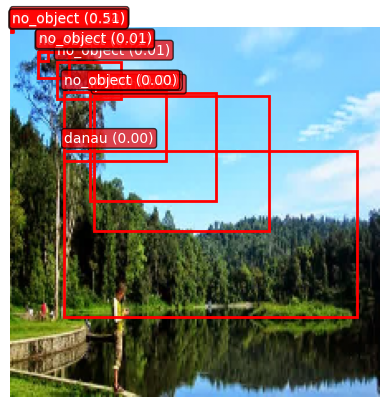

In [ ]:
def predict_and_visualize(image_path, model, class_labels, image_size=224, CONFIDENCE_THRESHOLD=0.001):
    img = load_and_preprocess_image(image_path)
    img_input = np.expand_dims(img, axis=0)

    pred_bbox, pred_class = model.predict(img_input)
    pred_bbox = pred_bbox[0]
    pred_class = pred_class[0]

    # Ambil label prediksi & confidence
    pred_class_labels = np.argmax(pred_class, axis=-1)
    confidence_scores = np.max(pred_class, axis=-1)

    # Filter hanya bounding box yang valid & confident
    valid_bboxes = []
    valid_class_indices = []
    valid_confidences = []

    for bbox, cls_idx, conf in zip(pred_bbox, pred_class_labels, confidence_scores):
        if np.sum(bbox) > 0 and conf >= CONFIDENCE_THRESHOLD:
            valid_bboxes.append(bbox)
            valid_class_indices.append(int(cls_idx))
            valid_confidences.append(conf)

    # Konversi ke nama kelas
    predicted_class_names = [class_mapping[i] for i in valid_class_indices]

    # ✅ Tampilkan hasil
    print("Predicted Class Indices:", valid_class_indices)
    print("Predicted Class Names  :", predicted_class_names)
    print("Confidence Scores       :", valid_confidences)

    # Visualisasi
    plt.imshow(img)
    ax = plt.gca()

    for bbox, class_name, conf in zip(valid_bboxes, predicted_class_names, valid_confidences):
        xmin, ymin, xmax, ymax = bbox * image_size
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 5, f"{class_name} ({conf:.2f})", color='white', fontsize=10,
                 bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))

    plt.axis('off')
    plt.show()


# Coba prediksi pada gambar baru
predict_and_visualize("/content/drive/MyDrive/Skripsi/Uji/Image_3.jpg", model_detection, class_labels=list(class_mapping.keys()))